### **Simulation: CT image reconstruction**
This code accompanies the paper:<br>
*Convergence for nonconvex ADMM, with applications to CT imaging.*<br>
Rina Foygel Barber and Emil Y. Sidky. [arXiv:2006.07278](http://arxiv.org/abs/2006.07278)<br>
This script modifies the CT imaging simulation in the paper to include total variation (TV) regularization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

In [2]:
# parameters for the scanning setup
nx, ny = 25, 25 # dimension of image
ns, nu = 50, 50 # number of source locations, number of detector cells
scanner_rad = 30 # radius from center to gantry (cm)
image_side = 10 # length of one side of square image array (cm)
theta = 4*np.arcsin(image_side/(np.sqrt(2.0)*scanner_rad)) # angle of the beam (radians)
phantom_rad = 5 # radius of the circular phantom (cm)
nk, nl = nx*ny, ns*nu # number of pixels, number of rays
energies = np.arange(1,100,2); ni = len(energies); energy_binwidth=2 # discretizing photon energy (keV)
nw = 3 # number of energy windows in detector
nm = 3 # number of materials
total_intensity = 10**6 # intensity of the X-ray beam (expected # of photons per detector cell for air scan)

#### **Scanner diagram**
To interpret the parameters defined above, the geometric layout of the scanner is illustrated in this figure:
![scanner_layout.png](https://drive.google.com/uc?export=view&id=1KSSW-pPll5pw64AsET8fizpY5GU5-NM0)

In [3]:
# parameters for optimization
sig_grid = np.array([1,10,100]) # ADMM parameter
nsig = len(sig_grid)
niter = 1000 # number of ADMM iterations
lamTV = 5 # total variation penalty when simulation is run with regularization
div_by_zero_thresh = 1e-8 # avoid dividing by zero with step size matrices
niter_newton = 10 # Newton-Raphson algorithm for solving convex subproblem

#### **Generate true image**
The true image consists of a 2D version of the standard rod phantom used for calibrating CT scanners.

The larger circle consists of 100% polymethyl methacrylate (PMMA), a plastic.
Two of the smaller circles consist of 100% aluminum.
The other two consist of 99% PMMA and 1% gadolinium, a contrast material.

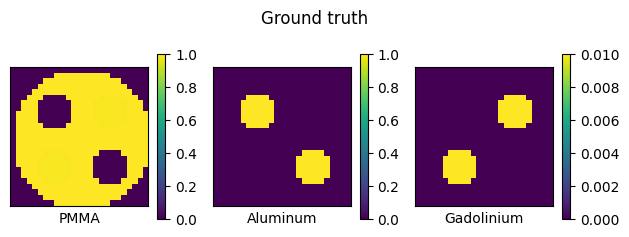

In [4]:
# generate phantom - a disk of pmma of radius phantom_rad,\
# with four smaller disks (two aluminum, two gadolinium/PMMA)
# centered at the points (+/- phantom_rad*0.4, +/- phantom_rad*0.4) with radius phantom_rad*0.25

x_true = np.zeros((nx,ny,nm))
materials_in_ball = np.array([[0,1,0],[0.99,0,0.01],[0,1,0],[0.99,0,0.01]])
ball_centers = np.array([[phantom_rad*0.4,phantom_rad*0.4],[phantom_rad*0.4,-phantom_rad*0.4],\
                         [-phantom_rad*0.4,-phantom_rad*0.4],[-phantom_rad*0.4,phantom_rad*0.4]])
ball_radii = np.array([phantom_rad*0.25,phantom_rad*0.25,phantom_rad*0.25,phantom_rad*0.25])
for ix in range(nx):
    for iy in range(ny):
        x_coord = (-image_side/2) + (image_side*ix)/float(nx)
        y_coord = (-image_side/2) + (image_side*iy)/float(ny)
        if x_coord**2+y_coord**2 <= phantom_rad**2:
            x_true[ix,iy,0] = 1
            for iball in range(len(ball_radii)):
                if (x_coord-ball_centers[iball,0])**2 + (y_coord-ball_centers[iball,1])**2 <\
                        ball_radii[iball]**2:
                    x_true[ix,iy] = materials_in_ball[iball]

def plot_x(x_list,title=None):
    vmin = np.ones(3)*np.inf
    vmax = np.ones(3)*-np.inf
    for x in x_list:
        vmin = np.minimum(vmin,x.min((0,1)))
        vmax = np.maximum(vmax,x.max((0,1)))
    for i in range(len(x_list)):
        plt.figure()
        plt.subplot(131)
        plt.imshow(x_list[i][:,:,0],vmin=vmin[0],vmax=vmax[0])
        plt.xlabel('PMMA')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(shrink=0.25)
        plt.subplot(132)
        plt.imshow(x_list[i][:,:,1],vmin=vmin[1],vmax=vmax[1])
        plt.xlabel('Aluminum')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(shrink=0.25)
        plt.subplot(133)
        plt.imshow(x_list[i][:,:,2],vmin=vmin[2],vmax=vmax[2])
        plt.xlabel('Gadolinium')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(shrink=0.25)
        plt.tight_layout()
        if(not(title is None)):
            plt.suptitle(title[i])
            plt.subplots_adjust(top=1.4)
        plt.show()

plot_x([x_true],title=['Ground truth'])

#### **Source/detector response**

The spectral CT detector has $n_w$ many energy windows, each detecting photons within a different range of energies.

The spectral response matrix $S$ has entries $S_{w,\ell,i}$, which indicate the source intensity & detector sensitivity for energy level $i$, along ray $\ell$, in energy window $w$. (In this simulation, the response is the same for each $\ell$, but in practice different detector cells in the scanner may have varying sensitivity.)

In [5]:
# create source/detector response S

# create window functions with linear blur
blur_prop = 0.1 # width of blur on each side as a function of width of total range
blur_width = blur_prop*(energies.max() - energies.min())/nw
w_breaks = np.r_[1.,50.,70.,99.]
w_breaks[0] -= blur_width
w_breaks[-1] += blur_width
w_shape = np.zeros((nw,ni))

spectrum = np.c_[np.arange(10,102,2), np.array([0.00368,0.00355,0.00459,0.0077,0.01474,\
  0.02249,0.02691,0.03264,0.03889,0.04088,0.04307,0.04396,0.04428,0.04315,0.04284,0.04095,\
  0.03944,0.03795,0.03627,0.0346,0.03267,0.03113,0.02894,0.02733,0.02647,0.05175,0.02204,\
  0.02084,0.01866,0.02607,0.01502,0.01218,0.01121,0.01026,0.0092,0.00854,0.00749,0.00682,\
  0.00579,0.00486,0.00417,0.00324,0.0024,0.00168,0.00114,0.00017])]
# These values are taken from the following paper:
# "Diagnostic x-ray spectra: A comparison of spectra generated by
#     different computational methods with a measured spectrum"
# Bhat et al, Med. Phys. 25(1), 1998
# (Table I)

spectrum = np.exp(np.interp(energies, spectrum[:,0], np.log(spectrum[:,1]), \
                            left = -np.inf, right = -np.inf))
spectrum /= spectrum.sum()

for w_ in range(nw):
    w_shape[w_] = \
      (1 - np.minimum(np.maximum((w_breaks[w_] + blur_width - energies)/2/blur_width,0),1)\
       - np.minimum(np.maximum((energies - w_breaks[w_+1] + blur_width)/2/blur_width,0),1))\
        * spectrum


S = total_intensity * np.outer(w_shape,np.ones(nl)).reshape((nw,ni,nl)).transpose((0,2,1))
# constant across rays l_=1,..,nl i.e. no differences between different detector cells

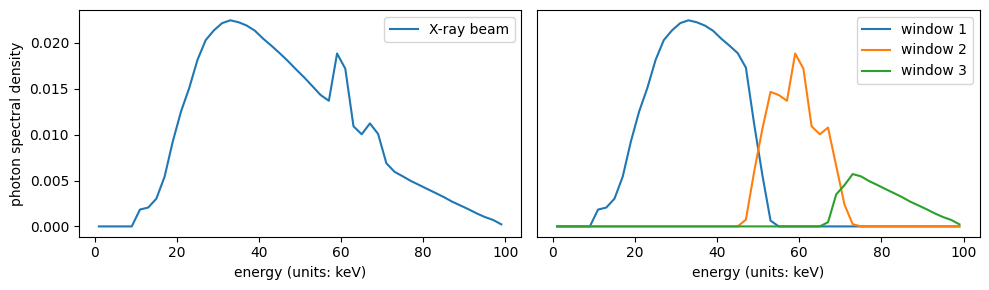

In [6]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(energies,spectrum/energy_binwidth,label='X-ray beam') # rescaling to obtain a density
plt.legend(loc='upper right')
plt.xlabel('energy (units: keV)')
plt.ylabel('photon spectral density')
plt.subplot(122)
plt.plot(energies,S[0,0]/total_intensity/energy_binwidth,label='window 1')
plt.plot(energies,S[1,0]/total_intensity/energy_binwidth,label='window 2')
plt.plot(energies,S[2,0]/total_intensity/energy_binwidth,label='window 3')
plt.legend(loc='upper right')
plt.xlabel('energy (units: keV)')
plt.yticks([])
plt.tight_layout()
plt.show()

#### **Attenuation coefficients**

The attentuation coefficients $\mu$ measure the physical properties of the materials present in the object.

For each material $m$ and energy $i$, $\mu_{im}$ measures the attenuation properties of material $m$ at energy level $i$. A larger value of $\mu_{im}$ indicates a higher probability that a photon at energy level $i$ will be absorbed when passing through material $m$.

In [7]:
# attenuation coefficients scraped from NIST
# and interpolated on the log scale to the predefined energy levels

# sources for density:
# PMMA: https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html
# aluminum & gadolinium: https://physics.nist.gov/PhysRefData/XrayMassCoef/tab1.html

# sources for mu_per_density (a.k.a mass attenuation coefficient):
# PMMA: https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/pmma.html
# aluminum: https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z13.html
# gadolinium: https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z64.html
# mu is the linear attenuation coefficient (1/cm)

density_PMMA = 1.190
mu_per_density_PMMA = np.array([\
        2.79400000e+03, 1.23600000e+02, 2.68100000e+01, 1.00166012e+01,\
        4.66908535e+00, 2.68607749e+00, 1.71970094e+00, 1.10100000e+00,\
        8.46931890e-01, 6.51492848e-01, 5.36313998e-01, 4.72472923e-01,\
        4.16231282e-01, 3.66684463e-01, 3.23035537e-01, 2.95571846e-01,\
        2.80886455e-01, 2.66930703e-01, 2.53668338e-01, 2.41064909e-01,\
        2.32082263e-01, 2.26355019e-01, 2.20769110e-01, 2.15321048e-01,\
        2.10007431e-01, 2.05848821e-01, 2.02781180e-01, 1.99759255e-01,\
        1.96782364e-01, 1.93849835e-01, 1.91495742e-01, 1.89699956e-01,\
        1.87921010e-01, 1.86158746e-01, 1.84413009e-01, 1.82683642e-01,\
        1.80970493e-01, 1.79273409e-01, 1.77592240e-01, 1.75926836e-01,\
        1.74532885e-01, 1.73404160e-01, 1.72282734e-01, 1.71168560e-01,\
        1.70061593e-01, 1.68961784e-01, 1.67869087e-01, 1.66783457e-01,\
        1.65704848e-01, 1.64633215e-01])
mu_PMMA = mu_per_density_PMMA * density_PMMA

density_aluminum = 2.699
mu_per_density_aluminum = np.array([\
        1.18500000e+03, 7.88000000e+02, 1.93400000e+02, 7.61777461e+01,\
        3.63339497e+01, 2.06617294e+01, 1.28204546e+01, 7.95500000e+00,\
        5.68928879e+00, 4.06888837e+00, 3.07784762e+00, 2.46247597e+00,\
        1.97013908e+00, 1.57623792e+00, 1.26109167e+00, 1.05329794e+00,\
        9.18407688e-01, 8.00792108e-01, 6.98238929e-01, 6.08819189e-01,\
        5.44319639e-01, 4.99000607e-01, 4.57454752e-01, 4.19367927e-01,\
        3.84452140e-01, 3.57884146e-01, 3.38295129e-01, 3.19778329e-01,\
        3.02275059e-01, 2.85729841e-01, 2.73395705e-01, 2.64795487e-01,\
        2.56465807e-01, 2.48398154e-01, 2.40584285e-01, 2.33016217e-01,\
        2.25686218e-01, 2.18586800e-01, 2.11710708e-01, 2.05050917e-01,\
        2.00100689e-01, 1.96744874e-01, 1.93445339e-01, 1.90201138e-01,\
        1.87011345e-01, 1.83875047e-01, 1.80791347e-01, 1.77759362e-01,\
        1.74778226e-01, 1.71847085e-01])
mu_aluminum = mu_per_density_aluminum * density_aluminum

density_gadolinium = 7.900
mu_per_density_gadolinium = np.array([\
        2291.        , 1292.        ,  365.3       ,  156.89085391,\
        353.5249706 ,  217.87728117,  142.61431975,   93.35      ,\
         68.86248306,   50.79851713,   39.16968525,   31.57038073,\
         25.44541609,   20.50875489,   16.52985455,   13.74995004,\
         11.80417281,   10.13374561,    8.6997032 ,    7.46859441,\
          6.52744112,    5.8078675 ,    5.16761841,    4.59794925,\
          4.09107942,   17.98139263,   16.35911816,   14.88320467,\
         13.54044755,   12.31883346,   11.31984357,   10.50619708,\
          9.75103377,    9.05015002,    8.39964431,    7.79589558,\
          7.23554304,    6.71546746,    6.23277381,    5.78477517,\
          5.41272081,    5.10585873,    4.81639351,    4.54333887,\
          4.28576446,    4.04279264,    3.81359557,    3.59739231,\
          3.39344622,    3.20106238])
mu_gadolinium = mu_per_density_gadolinium * density_gadolinium

mu = np.c_[mu_PMMA,mu_aluminum,mu_gadolinium].T

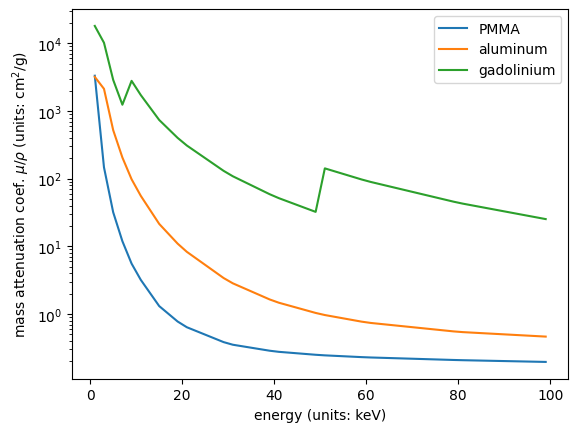

In [8]:
plt.plot(energies,mu_PMMA,label='PMMA')
plt.plot(energies,mu_aluminum,label='aluminum')
plt.plot(energies,mu_gadolinium,label='gadolinium')
plt.legend(loc='upper right')
plt.xlabel('energy (units: keV)')
plt.ylabel('mass attenuation coef. '+r'$\mu/\rho$'+' (units: cm'+r'${}^2$'+'/g)')
plt.yscale('log')
plt.show()

#### **Projection matrix**

The projection matrix $P$ is a linear operator mapping an image $x$ to its projections $y$.

Specifically, for an image $x$ where $x_{km}$ is the amount of material $m$ present in pixel $x$, its projection $Px$ has entries $(Px)_{\ell m}$ that measures the amount of material $m$ present along ray $\ell$.

The projection matrix is defined by calculating the length of the intersection of ray $\ell$ with pixel $k$, for each $\ell$ and $k$.

In [9]:
# create projection matrix
P = np.zeros((ns,nu,nx,ny))
pixel_xs = -image_side/2+image_side*np.arange(1+nx)/nx
pixel_ys = -image_side/2+image_side*np.arange(1+ny)/ny

for s_ in range(ns):
    for u_ in range(nu):
        # compute length of intersection between pixel x,y and ray s,u
        source_angle = s_*2*np.pi/float(ns)
        source = np.r_[scanner_rad*np.cos(source_angle), scanner_rad*np.sin(source_angle)]
        # coordinates of source location

        detector_angle = source_angle + np.pi - (0.5-0.5/nu)*theta + u_*theta/float(nu)
        detector = np.r_[scanner_rad*np.cos(detector_angle), scanner_rad*np.sin(detector_angle)]
        # coordinates of detector cell location

        t_vals = np.zeros(0)
        if(source[0]!=detector[0]):
            t_vals = np.r_[t_vals, (pixel_xs - source[0])/(detector[0] - source[0])]
        if(source[1]!=detector[1]):
            t_vals = np.r_[t_vals, (pixel_ys - source[1])/(detector[1] - source[1])]
        t_vals = np.sort(np.unique(t_vals))
        t_vals = np.r_[0,t_vals[(0<t_vals) & (t_vals<1)],1]

        length = np.sqrt(((source-detector)**2).sum())

        for it in range(len(t_vals)-1):
            t = (t_vals[it] + t_vals[it+1])/2
            x_coord = (1-t) * source[0] + t * detector[0]
            y_coord = (1-t) * source[1] + t * detector[1]
            if((pixel_xs[0]<=x_coord)&(x_coord<=pixel_xs[nx])&(pixel_ys[0]<=y_coord)&(y_coord<=pixel_ys[ny])):
                ix = np.argwhere(pixel_xs<=x_coord).max()
                iy = np.argwhere(pixel_ys<=y_coord).max()
                P[s_,u_,ix,iy] = P[s_,u_,ix,iy] + length * (t_vals[it+1]-t_vals[it])



P = P.reshape((nl,nx,ny))

def Pmult(x): # apply projection operator to an image x
    Px = np.zeros((nl,nm))
    for m_ in range(nm):
        Px[:,m_] = (P*x[:,:,m_]).sum((1,2))
    return Px

def Ptmult(y): # transpose of the projection operator
    return np.dot(P.transpose((1,2,0)),y)

P_rowsums = Pmult(np.ones((nx,ny,nm)))[:,0]
P_rowsums[P_rowsums<div_by_zero_thresh] = div_by_zero_thresh # avoiding dividing by zero
P_colsums = Ptmult(np.ones((nl,nm)))[:,:,0]
P_colsums[P_colsums<div_by_zero_thresh] = div_by_zero_thresh # avoiding dividing by zero

#### **Approximating the exponential function**

The "qexp" function is used as a replacement to $e^t$, returning $e^t$ exactly for $t\leq 0$ or replacing with a quadratic approximation for $t>0$:
$$\text{qexp}(t) = \begin{cases} e^t, & t\leq 0,\\
1 + t + \frac{1}{2}t^2, & t>0.\end{cases}$$

Its first derivative is equal to:
$$\text{qexp}'(t) = \begin{cases} e^t, & t\leq 0,\\
1 + t, & t>0.\end{cases}$$

Its second derivative is equal to:
$$\text{qexp}''(t) = \begin{cases} e^t, & t\leq 0,\\
1, & t>0.\end{cases}$$

In [10]:
def qexp(t,deriv=0):
    return np.exp(t*(t<=0))*(t<=0) + \
            (1+t+0.5*t**2)*((t>0)&(deriv==0)) + (1+t)*((t>0)&(deriv==1)) + ((t>0)&(deriv==2))

#### **Expected photon counts**

Given an image $x$ and its projection $y = Px$, the expected photon count along ray $\ell$ in energy window $w$ is
$$\hat{C}_{w\ell}(y) = \sum_i \hat{C}_{w\ell i}(y)$$
where $\hat{C}_{w\ell i}(y)$ is the expected photon count along ray $\ell$ in energy window $w$ when counting only photons of energy $i$, which is defined by
$$\hat{C}_{w\ell i}(y) = S_{w\ell i} \text{qexp}\left\{ - \sum_m y_{\ell m} \mu_{mi}\right\}.$$

For later use in calculating derivatives, we also define these quantities with $\text{qexp}'$ or $\text{qexp}''$ in place of $\text{qexp}$:
$$\hat{C}^{(1)}_{w\ell i}(y) = S_{w\ell i} \text{qexp}'\left\{ - \sum_m y_{\ell m} \mu_{mi}\right\}$$
and
$$\hat{C}^{(2)}_{w\ell i}(y) = S_{w\ell i} \text{qexp}''\left\{ - \sum_m y_{\ell m} \mu_{mi}\right\}.$$
Note that $S_{w\ell i}$ includes the energy binwidth, so that summation over $i$ approximates continuous integration over $E$.

In [11]:
def get_c_hat_by_energy(y,deriv=0):
    # c_hat[w,l,i] = E[# photons in (w,l) at energy i]
    return (S * qexp(-np.dot(y,mu),deriv))

def get_c_hat(y,deriv=0):
    # c_hat[w,l] = E[# photons in (w,l), across all energies]
    return get_c_hat_by_energy(y,deriv).sum(2)

c = np.random.poisson(get_c_hat(Pmult(x_true))) # generate data

#### **Objective function**

We work with the Poisson negative log-likelihood: given observed photon counts $C = (C_{w\ell})$,
the negative log-likelihood for an image $x$ and its projection $y=Px\in\mathbb{R}^{n_\ell\times n_m}$ is equal to
$$\text{negLogLik}(y) = \sum_{w,\ell} \hat{C}_{w\ell}(y) - C_{w\ell}\log\big(\hat{C}_{w\ell}(y)\big) + \text{(terms not depending on $y$)}.$$
It is convenient to add some constant terms as follows:
$$g(y) = \sum_{w,\ell} \hat{C}_{w\ell}(y) - C_{w\ell} - C_{w\ell}\log\left(\frac{\hat{C}_{w\ell}(y)}{C_{w\ell}}\right).$$
This modification does not alter the minimization problem, but it ensures that $g(y)\geq 0$ for all $y$, with $g(y)=0$ if and only if $\hat{C}_{w\ell}(y) = C_{w\ell}$ for all $w,\ell$.
Since we may sometimes have zero counts (i.e., $C_{w\ell}=0$ for some $w,\ell$), formally we will define $0\cdot\log(0) = 0$ in order for this function to be well defined.
Our optimization problem is therefore
$$\arg\min_{x\in\mathbb{R}^{n_k\times n_m}}g(Px).$$

#### **Convex+differentiable decomposition**

To solve the minimization problem, we will decompose the objective function $g(y)$ into two terms:
$$g_c(y) = \sum_{w,\ell} \hat{C}_{w\ell}(y) - C_{w\ell}, \ \ \ \
g_d(y) = - \sum_{w,\ell} C_{w\ell}\log\left(\frac{\hat{C}_{w\ell}(y)}{C_{w\ell}}\right).$$

Next we can calculate gradients: for each $\ell,m$,
\begin{align*}\frac{\partial}{\partial y_{\ell m}}g_c(y)
&=
\sum_w \frac{\partial}{\partial y_{\ell m}}\hat{C}_{w\ell}(y)
= \sum_w \frac{\partial}{\partial y_{\ell m}}\left( \sum_i S_{w\ell i}\text{qexp}\left\{-\sum_{m'}y_{\ell m'}\mu_{m'i}\right\}\right) \\
&= - \sum_{wi}\mu_{mi} \cdot S_{w\ell i}\text{qexp}'\left\{ - \sum_{m'} y_{\ell m'} \mu_{m'i}\right\}
= - \sum_{wi}\mu_{mi} \cdot \hat{C}^{(1)}_{w\ell i}(y)\end{align*}
and
$$
\frac{\partial}{\partial y_{\ell m}}g_d(y)
= - \sum_w C_{w\ell} \frac{\partial}{\partial y_{\ell m}}\log\left(\hat{C}_{w\ell}(y)\right)
=  \sum_w C_{w\ell}\frac{-\frac{\partial}{\partial y_{\ell m}}\hat{C}_{w\ell}(y)}{\hat{C}_{w\ell}(y)}
=  \sum_w C_{w\ell}\frac{\sum_i \mu_{mi} \cdot \hat{C}^{(1)}_{w\ell i}(y)}{\hat{C}_{w\ell}(y)}.
$$

Finally we calculate the second derivative of $g_c$.
First, for $\ell\neq \ell'$ we can easily see that
$$ \frac{\partial^2}{\partial y_{\ell m}\partial y_{\ell'm'}}g_c(y)=0,$$
while for any $\ell,m,m'$, we calculate
\begin{align*}\frac{\partial^2}{\partial y_{\ell m}\partial y_{\ell m'}}g_c(y)
&=\frac{\partial}{\partial y_{\ell m}}\left(- \sum_{wi}\mu_{m'i} \cdot \hat{C}^{(1)}_{w\ell i}(y)\right)
=- \sum_{wi}\mu_{m'i} \cdot \frac{\partial}{\partial y_{\ell m}}\hat{C}^{(1)}_{w\ell i}(y)\\
&=- \sum_{wi}\mu_{m'i} \cdot \frac{\partial}{\partial y_{\ell m}}\left(S_{w\ell i}\text{qexp}'\left\{-\sum_{m''}y_{\ell m''}\mu_{m''i}\right\}\right) \\
&= - \sum_{wi}\mu_{m'i} \cdot  -\mu_{mi}\cdot S_{w\ell i}\text{qexp}''\left\{ - \sum_{m''} y_{\ell m''} \mu_{m''i}\right\}
= \sum_{wi}\mu_{mi}\mu_{m'i} \cdot \hat{C}^{(2)}_{w\ell i}(y).\end{align*}

In [12]:
def get_loss(x,c):
    # poisson negative log likelihood, up to a constant term
    #   ( this constant term makes it nonnegative, & ensures that if c = c_hat then loss = 0 )
    c_hat = get_c_hat(Pmult(x))
    if min(c_hat[c>0])<=0:
        return np.inf
    else:
        return (c_hat.sum() - c.sum()) - (c[c>0]*np.log(c_hat[c>0]/c[c>0])).sum()

def get_gradient_expterm(y):
    # returns l-by-m gradient of the first term in the negative log likelihood
    c_hat_by_energy_1 = get_c_hat_by_energy(y,deriv=1)
    return -(mu[:,None,None,:] * c_hat_by_energy_1).sum((1,3)).T

def get_gradient_logexpterm(y,c):
    # returns l-by-m gradient of the second term in the negative log likelihood
    c_hat_by_energy_1 = get_c_hat_by_energy(y,deriv=1)
    c_hat = get_c_hat(y)
    c_hat[c_hat==0] = 1 # avoiding 0/0
    return (mu[:,None,None,:] * (c/c_hat)[:,:,None]*c_hat_by_energy_1).sum((1,3)).T

def get_hessian_expterm(y):
    # returns l-by-m-by-m 2nd derivative of the first term in the negative log likelihood
    c_hat_by_energy_2 = get_c_hat_by_energy(y,deriv=2)
    return (c_hat_by_energy_2.sum(0)[:,None,:]*mu).dot(mu.T)


### **Adding total variation regularization**

We will now consider a regularized version of the objective function:
$$\arg\min_{x\in\mathbb{R}^{n_k\times n_m}} \text{(Poisson neg. log-likelihood term)} + \text{(total variation penalty term)}.$$
The Poisson likelihood term will be defined as before, now denoted as $g^P$ rather than $g$:
$$\text{(Poisson neg. log-likelihood term)} = g^P(Px)$$
where for any $y^P\in\mathbb{R}^{n_\ell\times n_m}$ we define
$$g^P(y^P) = \sum_{w,\ell} \hat{C}_{w\ell}(y^P) - C_{w\ell} - C_{w\ell}\log\left(\frac{\hat{C}_{w\ell}(y^P)}{C_{w\ell}}\right).$$
To define the total variation penalty, we first define the differencing matrix $D$, a linear operator mapping $x\in\mathbb{R}^{n_k\times n_m}$ to $y^D=Dx\in\mathbb{R}^{n_e\times n_m}$, where $n_e$ is the number of edges in the (2-dimensional) grid defining the layout of the image $x$. The penalty term is then defined as
$$\text{(total variation penalty term)} = g^D(Dx)$$
where for any $y^D\in\mathbb{R}^{n_e\times n_m}$ we define
$$g^D(y^D) = \lambda\|y^D\|_{\ell_1/\ell_2} = \lambda \sum_{e=1}^{n_e}\sqrt{\sum_{m=1}^{n_m} (y^D_{em})^2}.$$
Here $\lambda>0$ is a penalty parameter, while the $\ell_1/\ell_2$ norm ensures that (for sufficiently large $\lambda$), we will have sparsity along the edges: $y^D_{e,*} = (Dx)_{e,*}\in\mathbb{R}^m$ will be zero for most edges $e$.

#### **Defining the differencing matrix**
For the 2-dimensional setting, it is convenient to represent $x$ as a $n_x\times n_y\times n_m$ array, where $n_k = n_x\dot n_y$, and to represent $y^D = (y^{D,r},y^{D,c})$, where $y^{D,r}\in\mathbb{R}^{(n_x-1)\times n_y\times n_m}$ captures differences in $x$ along the rows, while $y^{D,c}\in\mathbb{R}^{n_x\times (n_y-1) n_y\times n_m}$ captures differences in $x$ along the columns.

In [13]:
def Dmult(x):
    return (x[1:] - x[:-1]),(x[:,1:] - x[:,:-1])

def Dtmult(yDr,yDc):
    return (np.r_[np.zeros((1,ny,nm)),yDr] - np.r_[yDr,np.zeros((1,ny,nm))] +\
            np.r_[np.zeros((1,nx,nm)),yDc.transpose((1,0,2))].transpose((1,0,2)) -\
                np.r_[yDc.transpose((1,0,2)),np.zeros((1,nx,nm))].transpose((1,0,2)))

Dr_rowsums,Dc_rowsums = np.ones((nx-1,ny))*2, np.ones((nx,ny-1))*2
D_colsums = np.zeros((nx,ny))
D_colsums[:-1,:] = D_colsums[:-1,:] +1
D_colsums[1:,:] = D_colsums[1:,:] +1
D_colsums[:,:-1] = D_colsums[:,:-1] +1
D_colsums[:,1:] = D_colsums[:,1:] +1

def get_pen_loss(x,c):
    lossP = get_loss(x,c)
    yDr,yDc = Dmult(x)
    lossD = lamTV * (np.sqrt((yDr**2).sum(2)).sum() + np.sqrt((yDc**2).sum(2)).sum())
    return lossP+lossD

#### **Objective function and its derivatives**

Our optimization problem is given by
$$\min_{x\in\mathbb{R}^{n_k\times n_m}}\left\{g^P(Px) + g^D(Dx)\right\},$$
which we rewrite as
$$\min_{\substack{x\in\mathbb{R}^{n_k\times n_m}\\ y = (y^P,y^D)\in\mathbb{R}^{n_\ell\times n_m}\times \mathbb{R}^{n_e\times n_m}}}\left\{g^P(y^P) + g^D(y^D) : y = \left(\begin{array}{c} P \\ D \end{array}\right)x \right\}.$$

We will decompose the function into two terms:
$$g_c(y) = g^P_c(y^P) + g^D(y^d), \quad g_d(y) = g^P_d(y^P),$$
where
$$g^P_c(y^P) = \sum_{w,\ell} \hat{C}_{w\ell}(y^P) - C_{w\ell}, \ \ \ \
g^P_d(y^P) = - \sum_{w,\ell} C_{w\ell}\log\left(\frac{\hat{C}_{w\ell}(y^P)}{C_{w\ell}}\right).$$

The derivatives of $g^P_c$ and $g^P_d$ are calculated exactly as for the unpenalized case:
for each $\ell,m$,
$$\frac{\partial}{\partial y^P_{\ell m}}g^P_c(y^P)
= - \sum_{wi}\mu_{mi} \cdot \hat{C}^{(1)}_{w\ell i}(y^P)$$
and
$$
\frac{\partial}{\partial y^P_{\ell m}}g^P_d(y^P)
=  \sum_w C_{w\ell}\frac{\sum_i \mu_{mi} \cdot \hat{C}^{(1)}_{w\ell i}(y^P)}{\hat{C}_{w\ell}(y^P)},
$$
and
$$\frac{\partial^2}{\partial y^P_{\ell m}\partial y^P_{\ell m'}}g^P_c(y^P)
= \sum_{wi}\mu_{mi}\mu_{m'i} \cdot \hat{C}^{(2)}_{w\ell i}(y^P)$$
while  $\frac{\partial^2}{\partial y^P_{\ell m}\partial y^P_{\ell' m'}}g^P_c(y^P) =0$ for $\ell\neq \ell'$.



#### **ADMM iterations**

The update steps of the ADMM algorithm, with $g_c$ treated exactly while $g_d$ is treated with a linear approximation, are as follows. The only free parameters are $\sigma^P,\sigma^D>0$, which controls the enforcement of the constraints $Px=y^P,Dx=y^D$.

* $x$ update step:
Since $f_c(x)=f_d(x)\equiv 0$, the $x$ update step is given by
$$x_{t+1} = \arg\min\left\{\frac{1}{2}\|x - x_t\|^2_{H_f} + \frac{1}{2}\left\|\left(\begin{array}{c}P\\D\end{array}\right)x - y_t\right\|^2_{\Sigma} + \left\langle u_t, \left(\begin{array}{c}P\\D\end{array}\right)x\right\rangle\right\},$$
where the step size matrix $H_f$ is defined by
$$H_f = Q_f - P^\top \Sigma^P P - D^\top \Sigma^D D$$
where the diagonal matrix $Q_f$ has entries
$$(Q_f)_{km,km} =
\sigma^P\sum_\ell P_{\ell k} + 4\sigma^D$$
while $\Sigma^P,\Sigma^D$ are defined as diagonal matrices with entries
$$\Sigma^P_{\ell m,\ell m} =
\sigma^P\left(\sum_k |P_{\ell k}|\right)^{-1}, \ \ \ \Sigma^D_{em, em} = \frac{1}{2}\sigma^D.$$
The $x$ update step can be explicitly calculated as
$$x_{t+1} = x_t + Q_f^{-1} \left(P^\top \Big( \Sigma^P (y^P_t - P x_t)  -u^P_t\Big) + D^\top \Big( \Sigma^D (y^D_t - D x_t)  -u^D_t\Big)\right).$$

$\ $

* $y^P$ update step:
Since $H_g=0$, the $y^P$ update step is given by
$$y^P_{t+1} = \arg\min g^P_t(y^P) \ \ \text{where} \ \ g^P_t(y^P) = g^P_c(y^P) + \langle y^P, \nabla g^P_d(y^P_t)\rangle + \frac{1}{2}\|Px_{t+1} - y^P\|^2_{\Sigma^P} - \langle u^P_t, y^P\rangle.$$
We will solve this approximately with $N$ iterations of the Newton-Raphson method. We can calculate
$$\nabla g^P_t(y^P) = \nabla g^P_c(y^P) + \nabla g^P_d(y^P_t) + \Sigma^P(y^P - Px_{t+1}) - u^P_t, \ \ \ \
\nabla^2 g^P_t(y^P) = \nabla^2 g^P_c(y^P) + \Sigma^P.$$
Let $(y^P_{t+1})^{(0)} = y^P_t$, and for each iteration $n=0,\dots,N-1$ define
$$(y^P_{t+1})^{(n+1)} = (y^P_t)^{(n)} - \big(\nabla^2 g^P_t((y^P_t)^{(n)})\big)^{-1} \nabla g^P_t((y^P_t)^{(n)}).$$
Finally, set $y^P_{t+1} = (y^P_{t+1})^{(N)}$.

$\ $

* $y^D$ update step:
Since $H_g=0$ and $g^D_c(y^D)=\lambda\|y^D\|_{\ell_1/\ell_2}$, the $y^D$ update step is given by
$$y^D_{t+1} = \arg\min \left\{ \lambda\|y^D\|_{\ell_1/\ell_2} + \frac{1}{2}\|Dx_{t+1} - y^D\|^2_{\Sigma^D} - \langle u^D_t, y^D\rangle\right\}.$$
Since $\Sigma^D$ is a diagonal matrix as defined above, this objective function separates over the edges $e=1,\dots,n_e$, and for each $e$ we have an optimization problem to solve for $(y^D_e)_{t+1}\in\mathbb{R}^{n_m}$:
$$(y^D_{t+1})_e = \arg\min \left\{ \lambda\|y^D_e\|_2 + \frac{\sigma^D}{2\sum_k D_{ek}}\|(Dx_{t+1})_e - y^D_e\|^2_2 - \langle (u^D_t)_e, y^D_e\rangle\right\}.$$
This is solved by
$$(y^D_{t+1})_e = \frac{(Dx_{t+1})_e + (\sigma^D)^{-1}\sum_k D_{ek}\cdot (u^D_t)_e}{\left\|(Dx_{t+1})_e + (\sigma^D)^{-1}\sum_k D_{ek}\cdot (u^D_t)_e\right\|_2} \cdot \max\left\{ \left\|(Dx_{t+1})_e + (\sigma^D)^{-1}\sum_k D_{ek} \cdot (u^D_t)_e\right\|_2 - \lambda \cdot (\sigma^D)^{-1}\sum_k D_{ek}, 0\right\}.$$

$\ $


* $u = (u^P,u^D)$ update step:
$u^P_{t+1} = u^P_t + \Sigma^P(Px_{t+1} - y^P_{t+1})$, $u^D_{t+1} = u^D_t + \Sigma^D(Dx_{t+1} - y^D_{t+1})$.



In [14]:
# ADMM update steps (with TV penalty)
def x_update_TV(x,yP,yDr,yDc,uP,uDr,uDc,c,sigP,sigD):
    return x + (Ptmult(sigP*(yP-Pmult(x))/P_rowsums[:,None]-uP)+\
            Dtmult(sigD*(yDr-Dmult(x)[0])/Dr_rowsums[:,:,None]-uDr,\
                   sigD*(yDc-Dmult(x)[1])/Dc_rowsums[:,:,None]-uDc))/\
                (sigP*P_colsums[:,:,None]+sigD*D_colsums[:,:,None])

def y_update_TV(x,yP,yDr,yDc,uP,uDr,uDc,c,sigP,sigD):
    grad_y = lambda y_: get_gradient_expterm(y_) + get_gradient_logexpterm(yP,c) \
                        + sigP*(y_-Pmult(x))/P_rowsums[:,None] - uP
    hess_y = lambda y_: get_hessian_expterm(y_) + sigP/P_rowsums[:,None,None] * np.eye(nm)
    y_ = np.copy(yP)
    for iter in range(niter_newton):
        y_ = y_ - np.linalg.solve(hess_y(y_),grad_y(y_))
    yDr = Dmult(x)[0] + 2*uDr/sigD
    yDr_mult = np.maximum(np.sqrt((yDr**2).sum(2)) - lamTV*Dr_rowsums[:,:]/sigD,0)
    yDr_mult = yDr_mult / (np.sqrt((yDr**2).sum(2)) + (yDr_mult==0))
    yDr = yDr * yDr_mult[:,:,None]
    yDc = Dmult(x)[1] + 2*uDc/sigD
    yDc_mult = np.maximum(np.sqrt((yDc**2).sum(2)) - lamTV*Dc_rowsums[:,:]/sigD,0)
    yDc_mult = yDc_mult / (np.sqrt((yDc**2).sum(2)) + (yDc_mult==0))
    yDc = yDc * yDc_mult[:,:,None]
    return y_,yDr,yDc

def u_update_TV(x,yP,yDr,yDc,uP,uDr,uDc,c,sigP,sigD):
    return uP + sigP*(Pmult(x)-yP)/P_rowsums[:,None],\
        uDr + sigD*(Dmult(x)[0]-yDr)/Dr_rowsums[:,:,None],\
        uDc + sigD*(Dmult(x)[1]-yDc)/Dc_rowsums[:,:,None]

In [15]:
# run simulation (with TV penalty)
x_TV_store_iters = np.zeros((niter,nsig,nx,ny,nm))
yP_TV_store_iters = np.zeros((niter,nsig,nl,nm))
yDr_TV_store_iters = np.zeros((niter,nsig,nx-1,ny,nm))
yDc_TV_store_iters = np.zeros((niter,nsig,nx,ny-1,nm))
for isig in range(nsig):
    sigP = sig_grid[isig]
    sigD = sig_grid[isig]
    x = np.zeros((nx,ny,nm))
    yP = np.zeros((nl,nm))
    yDr = np.zeros((nx-1,ny,nm))
    yDc = np.zeros((nx,ny-1,nm))
    uP = np.zeros((nl,nm))
    uDr = np.zeros((nx-1,ny,nm))
    uDc = np.zeros((nx,ny-1,nm))
    for iter in range(niter):
        x = x_update_TV(x,yP,yDr,yDc,uP,uDr,uDc,c,sigP,sigD)
        yP,yDr,yDc = y_update_TV(x,yP,yDr,yDc,uP,uDr,uDc,c,sigP,sigD)
        uP,uDr,uDc = u_update_TV(x,yP,yDr,yDc,uP,uDr,uDc,c,sigP,sigD)
        x_TV_store_iters[iter,isig] = np.copy(x)
        yP_TV_store_iters[iter,isig] = np.copy(yP)
        yDr_TV_store_iters[iter,isig] = np.copy(yDr)
        yDc_TV_store_iters[iter,isig] = np.copy(yDc)

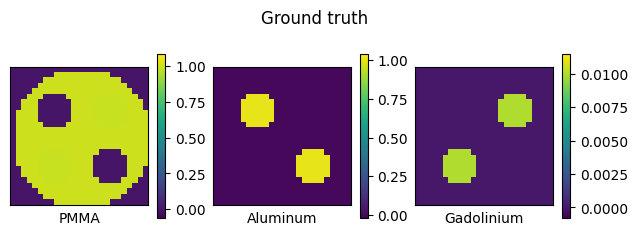

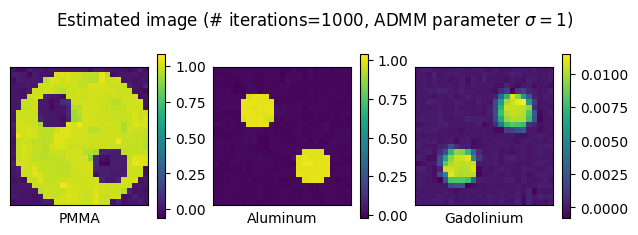

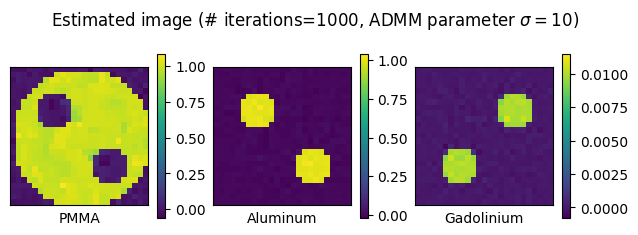

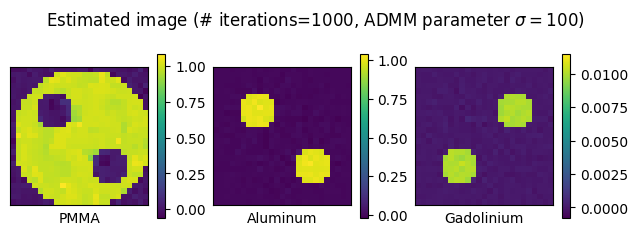

In [16]:
# plot results: true & estimated images (with TV penalty)

x_list = [x_true]
title_list = ['Ground truth']
for isig in range(nsig):
    x_list.append(x_TV_store_iters[-1,isig])
    title_list.append('Estimated image (# iterations='+str(niter)+\
            ', ADMM parameter '+r'$\sigma=$'+str(sig_grid[isig])+')')

plot_x(x_list,title_list)

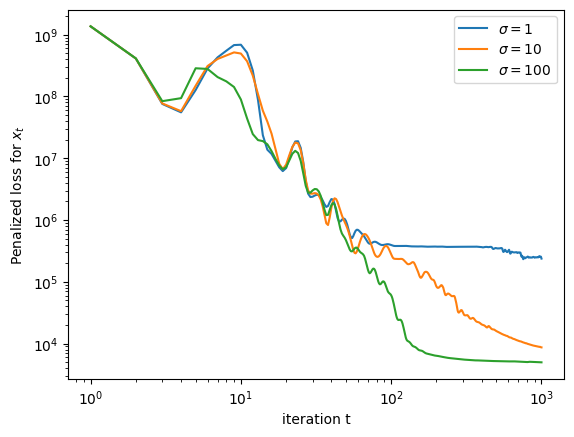

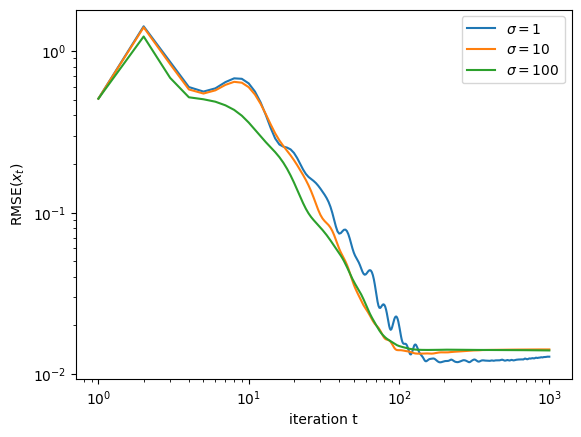

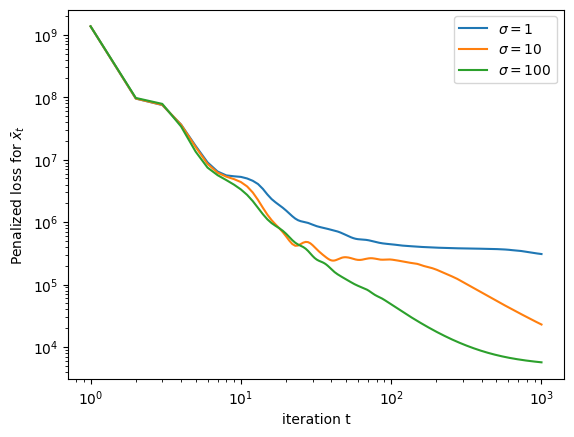

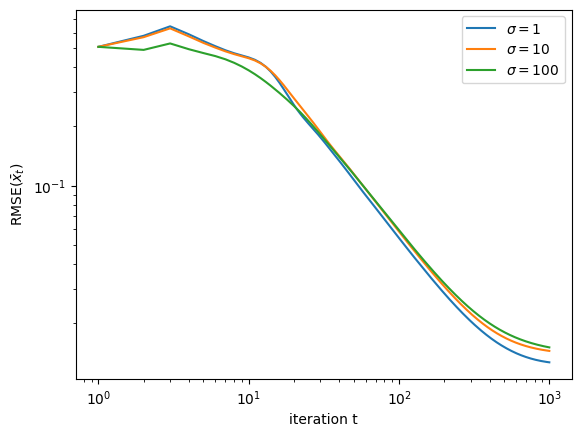

In [17]:
# plot results : loss function (with TV penalty) & RMSE

loss_by_iter = np.zeros((niter,nsig))
rmse_by_iter = np.zeros((niter,nsig))
loss_by_iter_xbar = np.zeros((niter,nsig))
rmse_by_iter_xbar = np.zeros((niter,nsig))
for iter in range(niter):
    for isig in range(nsig):
        loss_by_iter[iter,isig] = get_pen_loss(x_TV_store_iters[iter,isig],c)
        rmse_by_iter[iter,isig] = np.sqrt(np.mean((x_TV_store_iters[iter,isig]-x_true)**2))
        xbar = x_TV_store_iters[:(iter+1),isig].mean(0)
        loss_by_iter_xbar[iter,isig] = get_pen_loss(xbar,c)
        rmse_by_iter_xbar[iter,isig] = np.sqrt(np.mean((xbar-x_true)**2))

for isig in range(nsig):
    plt.plot((1+np.arange(niter)),loss_by_iter[:,isig],label=\
            r'$\sigma=$'+str(sig_grid[isig]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('iteration t')
plt.ylabel('Penalized loss for '+r'$x_t$')
plt.legend(loc = 'upper right')
plt.show()

for isig in range(nsig):
    plt.plot((1+np.arange(niter)),rmse_by_iter[:,isig],label=\
            r'$\sigma=$'+str(sig_grid[isig]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('iteration t')
plt.ylabel('RMSE'+r'$(x_t)$')
plt.legend(loc = 'upper right')
plt.show()

for isig in range(nsig):
    plt.plot((1+np.arange(niter)),loss_by_iter_xbar[:,isig],label=\
            r'$\sigma=$'+str(sig_grid[isig]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('iteration t')
plt.ylabel('Penalized loss for '+r'$\bar{x}_t$')
plt.legend(loc = 'upper right')
plt.show()

for isig in range(nsig):
    plt.plot((1+np.arange(niter)),rmse_by_iter_xbar[:,isig],label=\
            r'$\sigma=$'+str(sig_grid[isig]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('iteration t')
plt.ylabel('RMSE'+r'$(\bar{x}_t)$')
plt.legend(loc = 'upper right')
plt.show()

#### **TV constraint instead of TV penalty**
If desired, the TV penalty can be replaced by a constraint, with
$$g^D(y^D) = \begin{cases} 0, & \text{ if }\|y^D\|_{\ell_1/\ell_2}\leq \gamma,\\
 +\infty, & \text{ if }\|y^D\|_{\ell_1/\ell_2}>\gamma.\end{cases}$$
This is not implemented here, but the code can easily be modified as follows. The only change is in the $y^D$ update step, which is now the following:

* $y^D$ update step: For each $e=1,\dots,n_e$ define
$$v_e = (Dx_{t+1})_e + (\sigma^D)^{-1}\sum_k D_{ek}\cdot (u^D_t)_e.$$
If $\sum_{e=1}^{n_e} \|v_e\|_2 \leq \gamma$ then set
$$(y^D_{t+1})_e = v_e$$
for each $e=1,\dots,n_e$. If instead $\sum_{e=1}^{n_e} \|v_e\|_2 > \gamma$ then let $\lambda>0$
be the unique solution to
$$\sum_{e=1}^{n_e} \max\left\{\|v_e\| - \lambda\cdot (\sigma^D)^{-1}\sum_k D_{ek}, 0 \right\} = \gamma,$$
and then for each $e=1,\dots,n_e$ define
$$(y^D_{t+1})_e = \frac{v_e}{\|v_e\|_2} \cdot \max\left\{ \|v_e\|_2 - \lambda \cdot (\sigma^D)^{-1}\sum_k D_{ek}, 0\right\}.$$
